# Gramedia Digital - Data Engineer Take Home Test
## Notebook summary
by Mario Caesar // caesarmario87@gmail.com

---


# Intro
Notebook ini menganalisis dataset **L2** hasil pipeline (DAG 99) menggunakan file:
- `assets/sample_output/l2/cleaned_data.csv`
- `assets/sample_output/l2/dim_product.csv`
- Ringkasan Data Quality: `assets/sample_output/dq-reports/run_results.json`

# Tujuan:
1. Menyajikan metrik ringkas (Revenue, Orders, Items, Unique Products, AOV).
2. Visualisasi: tren penjualan harian, kategori teratas, produk teratas, serta distribusi harga.
3. Menyertakan snapshot hasil Data Quality untuk konteks validitas data.

In [4]:
# ==== Setup & Konfigurasi ====
import os, json
import pandas as pd
import matplotlib.pyplot as plt

from textwrap import dedent
from datetime import datetime
from IPython.display import display, Markdown

# --- Format sumber data ---
SOURCE = "csv"

# --- Paths CSV  ---
BASE = r"sample_output"
FACT_CSV = os.path.join(BASE, "l2", "cleaned_data.csv")
DIM_CSV  = os.path.join(BASE, "l2", "dim_product.csv")
RUN_RESULTS = os.path.join(BASE, "dq-reports", "run_results.json")

print("Using SOURCE:", SOURCE)
print("BASE:", BASE)

Using SOURCE: csv
BASE: sample_output


# 1) Load Data (CSV default)

In [5]:
# ==== Load Data ====
fact = pd.read_csv(FACT_CSV, parse_dates=["transaction_date","load_ds"], low_memory=False)
dim  = pd.read_csv(DIM_CSV)

# Tampilkan head & shape untuk sanity check

print("fact shape:", fact.shape)
print("dim shape :", dim.shape)

display(fact.head(3))
display(dim.head(3))

fact shape: (14, 9)
dim shape : (20, 5)


,transaction_id,product_id,product_name,category,quantity,price,total_sales,transaction_date,load_ds
0,49c5f530a8763fa64e2039c36c72d4e6,1,"Fjallraven - Foldsack No. 1 Backpack, Fits 15 ...",men's clothing,4.0,109.95,439.8,2020-01-01,2025-11-07
1,03dca7d1476be8aa9aa9356b0cbf373e,1,"Fjallraven - Foldsack No. 1 Backpack, Fits 15 ...",men's clothing,10.0,109.95,1099.5,2020-01-02,2025-11-07
2,0e9ba582dbd1ce622b7f3ad6ccd29c00,2,Mens Casual Premium Slim Fit T-Shirts,men's clothing,4.0,22.30,89.2,2020-01-02,2025-11-07


,product_id,product_name,category,price,last_ingested_ds
0,1,"Fjallraven - Foldsack No. 1 Backpack, Fits 15 ...",men's clothing,109.95,2025-11-07
1,2,Mens Casual Premium Slim Fit T-Shirts,men's clothing,22.30,2025-11-07
2,3,Mens Cotton Jacket,men's clothing,55.99,2025-11-07


# 2) Data Quality Snapshot

In [6]:
# ==== DQ Snapshot ====
try:
    rr = json.load(open(RUN_RESULTS))
    statuses = [r.get("status") for r in rr.get("results",[])]
    summary = pd.Series(statuses).value_counts().to_dict()
    display({"DQ summary": summary})
except Exception as e:
    print("DQ summary not available:", e)

{'DQ summary': {'success': 41}}

# 3) KPIs (Key Performance Indicators)

In [7]:
# ==== KPIs ====
orders = fact["transaction_id"].nunique() if "transaction_id" in fact.columns else fact["cart_id"].nunique()
revenue = float(fact["total_sales"].sum())
items   = int(fact["quantity"].sum())
unique_products = fact["product_id"].nunique()
aov = revenue / orders if orders else 0.0

kpi_df = pd.DataFrame([{
    "Revenue": revenue,
    "Orders": orders,
    "Items": items,
    "Unique Products": unique_products,
    "AOV": aov
}])
display(kpi_df)

,Revenue,Orders,Items,Unique Products,AOV
0,4691.27,14,42,10,335.090714


# 4) Visualizations

## 4.1) Daily Sales Trend

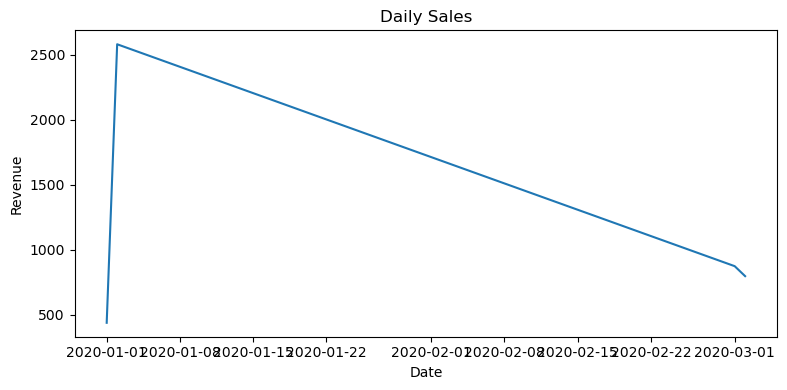

In [8]:
# ==== Daily Sales Trend ====
daily = fact.groupby(fact["transaction_date"].dt.date)["total_sales"].sum()
plt.figure(figsize=(8,4))
daily.plot(kind="line")
plt.title("Daily Sales")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

## 4.2) Top Categories by Revenue

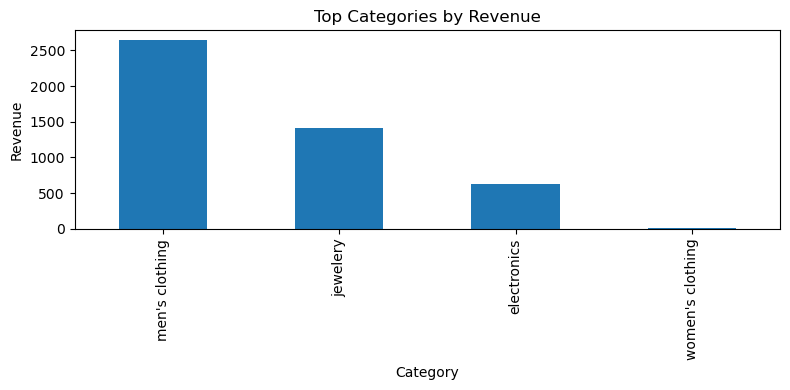

In [9]:
# ==== Top Categories ====
cat = fact.groupby("category")["total_sales"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(8,4))
cat.plot(kind="bar")
plt.title("Top Categories by Revenue")
plt.xlabel("Category")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

## 4.3) Top Products by Revenue

C:\Users\Mario Caesar\AppData\Local\Temp\ipykernel_15268\586109354.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


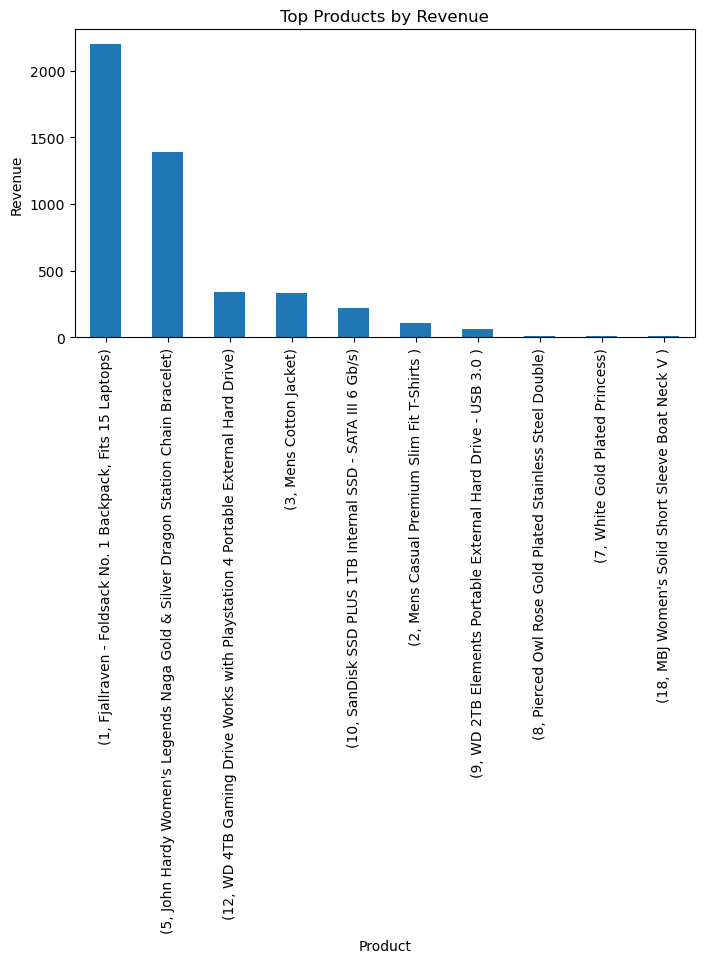

In [10]:
# ==== Top Products ====
prod = fact.groupby(["product_id","product_name"])["total_sales"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(8,4))
prod.plot(kind="bar")
plt.title("Top Products by Revenue")
plt.xlabel("Product")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

## 4.4) Product Price Distribution (DIM)

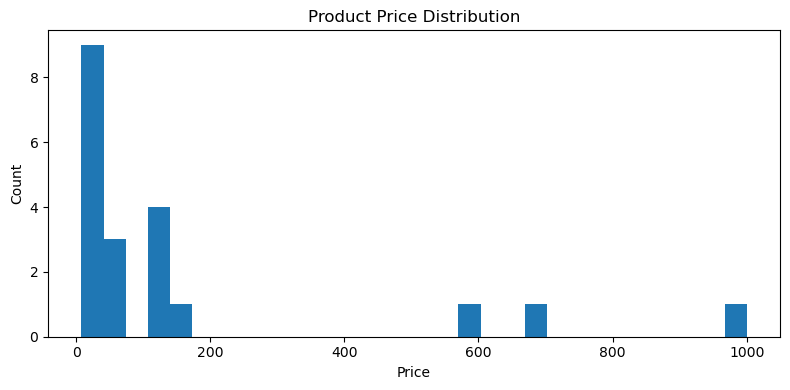

In [11]:
# ==== Price Distribution ====
plt.figure(figsize=(8,4))
dim["price"].dropna().plot(kind="hist", bins=30)
plt.title("Product Price Distribution")
plt.xlabel("Price")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## 4.5) Report Summary

In [12]:
# ==== Insights ====
# Day with highest revenue
daily_rev = fact.groupby(fact["transaction_date"].dt.date)["total_sales"].sum()
top_day = daily_rev.idxmax() if not daily_rev.empty else None
top_day_val = float(daily_rev.max()) if not daily_rev.empty else None

# Top category by revenue
cat_rev = fact.groupby("category")["total_sales"].sum().sort_values(ascending=False)
top_cat = cat_rev.index[0] if not cat_rev.empty else None
top_cat_val = float(cat_rev.iloc[0]) if not cat_rev.empty else None

# Top product by revenue
prod_rev = fact.groupby(["product_id","product_name"])["total_sales"].sum().sort_values(ascending=False)
if not prod_rev.empty:
    (top_pid, top_pname), top_prod_val = prod_rev.index[0], float(prod_rev.iloc[0])
else:
    top_pid, top_pname, top_prod_val = None, None, None

INSIGHT_MD = f"""
**Ringkasan Primary Fndings**

- **Total Revenue**: {revenue:,.2f}
- **Total Orders**: {orders:,}
- **Total Items**: {items:,}
- **Unique Products**: {unique_products:,}
- **Average Order Value (AOV)**: {aov:,.2f}

- **Kategori teratas** (berdasarkan revenue): {top_cat if top_cat else '-'} ({top_cat_val:,.2f} jika tersedia)
- **Produk teratas** (berdasarkan revenue): {top_pname if top_pname else '-'} (ID: {top_pid if top_pid else '-'}) {f'— {top_prod_val:,.2f}' if top_prod_val is not None else ''}
- **Hari dengan performance terbaik**: {top_day if top_day else '-'} {f'— {top_day_val:,.2f}' if top_day_val is not None else ''}

Interpretasi:
- Tren penjualan harian menunjukkan {('puncak yang jelas pada ' + str(top_day)) if top_day else 'pola yang relatif stabil'}.
- Komposisi revenue didorong oleh kategori **{top_cat if top_cat else 'N/A'}**; fokus promosi dan stok di kategori ini dapat meningkatkan performa.
- Produk **{top_pname if top_pname else 'N/A'}** berkontribusi signifikan; pertimbangkan strategi bundling atau cross-sell untuk memaksimalkan nilai pesanan.
"""

# Tampilkan sebagai Markdown di notebook
display(Markdown(INSIGHT_MD))


**Ringkasan Primary Fndings**

- **Total Revenue**: 4,691.27
- **Total Orders**: 14
- **Total Items**: 42
- **Unique Products**: 10
- **Average Order Value (AOV)**: 335.09

- **Kategori teratas** (berdasarkan revenue): men's clothing (2,646.44 jika tersedia)
- **Produk teratas** (berdasarkan revenue): Fjallraven - Foldsack No. 1 Backpack, Fits 15 Laptops (ID: 1) — 2,199.00
- **Hari dengan performance terbaik**: 2020-01-02 — 2,578.70

Interpretasi:
- Tren penjualan harian menunjukkan puncak yang jelas pada 2020-01-02.
- Komposisi revenue didorong oleh kategori **men's clothing**; fokus promosi dan stok di kategori ini dapat meningkatkan performa.
- Produk **Fjallraven - Foldsack No. 1 Backpack, Fits 15 Laptops** berkontribusi signifikan; pertimbangkan strategi bundling atau cross-sell untuk memaksimalkan nilai pesanan.
